In [1]:
import shutil
import glob
import matplotlib.pyplot as plt
import json
import math
import cv2
import os
#shutil.rmtree('/kaggle/working/augmented')

In [2]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [3]:
import shutil
import glob
import matplotlib.pyplot as plt
import json
import math
import cv2
import os
#shutil.rmtree('/kaggle/working/augmented')
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import seaborn as sns 
from sklearn.utils import resample

%matplotlib inline

In [4]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

def processing2(img_path):
    img = cv2.imread(img_path)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (150,150))
    image = cv2.medianBlur(image, 5)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image[:, :, 2] = cv2.equalizeHist(image[:, :, 2])
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    cv2.imwrite(img_path,image)

In [5]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [6]:
os.mkdir('augmented')
os.mkdir('augmented/benign')
os.mkdir('augmented/malignant')

In [7]:
files_benign=getListOfFiles('../input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign')
for f in files_benign:
    if f.endswith('.png'):
        shutil.copy(f,'augmented/benign')

In [8]:
files_malignant=getListOfFiles('../input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant')
for f in files_malignant:
    if f.endswith('.png'):
        shutil.copy(f,'augmented/malignant')

In [9]:
benign_images = np.array(Dataset_loader('augmented/benign',150))
malignent_images = np.array(Dataset_loader('augmented/malignant',150))

100%|██████████| 5429/5429 [01:21<00:00, 66.54it/s]


In [10]:
print(benign_images.shape)
print(malignent_images.shape)

(2480, 150, 150, 3)
(5429, 150, 150, 3)


In [11]:
benign_upsampled = resample(benign_images,n_samples=malignent_images.shape[0],random_state=42)
len(benign_upsampled)

5429

In [12]:
whole_data = np.array([])
whole_data

array([], dtype=float64)

In [13]:
whole_data = np.concatenate((benign_upsampled, malignent_images), axis=0)
len(whole_data)

10858

In [14]:
whole_data.shape

(10858, 150, 150, 3)

In [15]:
labels = np.concatenate((np.zeros(len(benign_upsampled)),np.ones(len(malignent_images))))
labels

array([0., 0., 0., ..., 1., 1., 1.])

In [16]:
labels.shape

(10858,)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(whole_data, labels, test_size=0.25,random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42, test_size=0.2 , shuffle=True)

In [18]:
X_train.shape

(8143, 150, 150, 3)

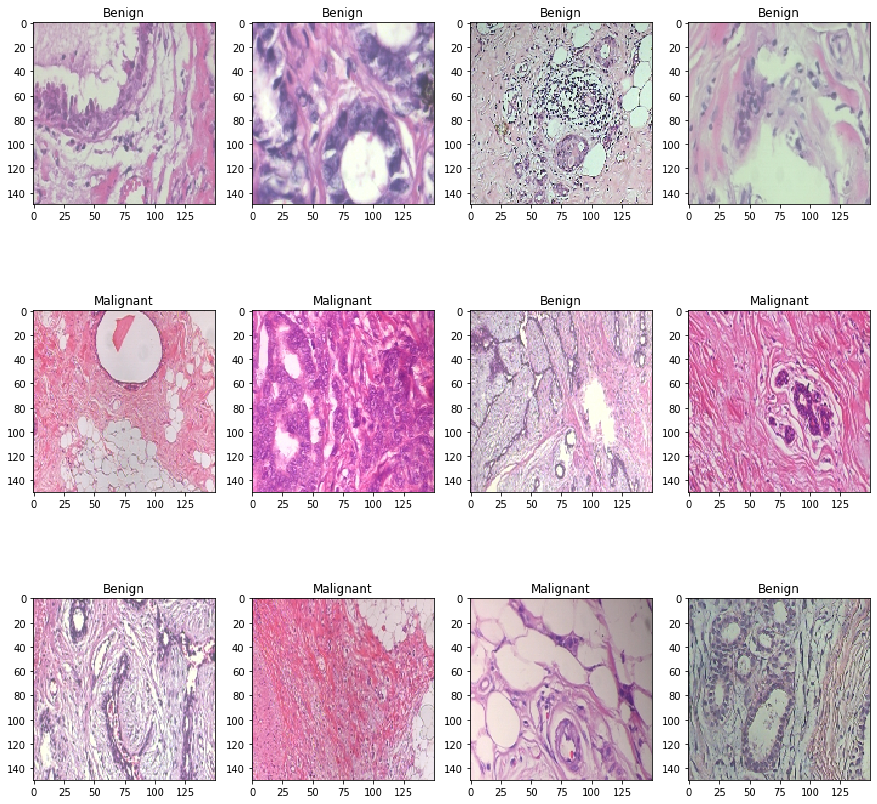

In [19]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3
title = ''
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        title='Benign'
    else:
        title='Malignant'
    ax.title.set_text(title)
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [20]:
BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2,  
        rotation_range = 90,
        horizontal_flip=True,  
        vertical_flip=True)

In [21]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, RMSprop

In [23]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

In [24]:
K.clear_session()
gc.collect()

def create_model():
    json_file = open('../input/models/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('../input/models/weights.best.hdf5')
    
    for layer in loaded_model.layers[-4:]:
        layer.trainable = False

    for layer in loaded_model.layers:
        print(layer, layer.trainable)
    
    model = Sequential(loaded_model.layers[:-1], name='dense2')
    
    model.add(BatchNormalization(name='batch'))

    model.add(Flatten(name='flatten2'))

    model.add(Dense(256, activation='relu', name='dense1', kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.001)))
    model.add(Dropout(0.5, name='drop'))
    model.add(Dense(1, activation='sigmoid', name='dense2'))   
    model.summary()
    
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    rms = RMSprop(lr=2e-5)
    
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['acc',f1_m])
    
    return model

In [25]:
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization

In [32]:
model = create_model()

<keras.engine.input_layer.InputLayer object at 0x7f4398211dd0> True
<keras.layers.convolutional.Conv2D object at 0x7f4398215310> True
<keras.layers.convolutional.Conv2D object at 0x7f4398211f90> True
<keras.layers.pooling.MaxPooling2D object at 0x7f4398215cd0> True
<keras.layers.convolutional.Conv2D object at 0x7f4398218250> True
<keras.layers.convolutional.Conv2D object at 0x7f4398218690> True
<keras.layers.pooling.MaxPooling2D object at 0x7f4398211d90> True
<keras.layers.convolutional.Conv2D object at 0x7f43a007d290> True
<keras.layers.convolutional.Conv2D object at 0x7f43ab082210> True
<keras.layers.convolutional.Conv2D object at 0x7f43ab05cf90> True
<keras.layers.pooling.MaxPooling2D object at 0x7f439821c950> True
<keras.layers.convolutional.Conv2D object at 0x7f439821cf10> True
<keras.layers.convolutional.Conv2D object at 0x7f4398220310> True
<keras.layers.convolutional.Conv2D object at 0x7f4398220910> True
<keras.layers.pooling.MaxPooling2D object at 0x7f43ab05af10> True
<keras.l

In [27]:
_y_test = []
_y_val = []
_y_train = []
for i in y_test:
    _y_test.append(int(i))
for i in y_train:
    _y_train.append(int(i))
for i in y_val:
    _y_val.append(int(i))

In [33]:
history = model.fit(
    train_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(X_val, y_val))

Epoch 1/15
508/508 [==============================] - 56s 109ms/step - loss: 4.2046 - acc: 0.6839 - f1_m: 0.6822 - val_loss: 4.3665 - val_acc: 0.5138 - val_f1_m: 0.0000e+00
Epoch 2/15
508/508 [==============================] - 55s 108ms/step - loss: 3.6642 - acc: 0.8158 - f1_m: 0.8114 - val_loss: 3.5562 - val_acc: 0.7569 - val_f1_m: 0.6727
Epoch 3/15
508/508 [==============================] - 55s 107ms/step - loss: 3.2582 - acc: 0.8429 - f1_m: 0.8365 - val_loss: 3.0556 - val_acc: 0.8582 - val_f1_m: 0.8342
Epoch 4/15
508/508 [==============================] - 55s 108ms/step - loss: 3.0248 - acc: 0.7551 - f1_m: 0.7596 - val_loss: 2.7015 - val_acc: 0.8711 - val_f1_m: 0.8647
Epoch 5/15
508/508 [==============================] - 55s 108ms/step - loss: 2.5969 - acc: 0.8427 - f1_m: 0.8369 - val_loss: 2.4421 - val_acc: 0.8471 - val_f1_m: 0.8084
Epoch 6/15
508/508 [==============================] - 54s 107ms/step - loss: 2.2817 - acc: 0.8556 - f1_m: 0.8491 - val_loss: 2.1792 - val_acc: 0.8361 -

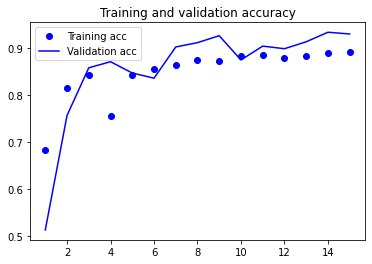

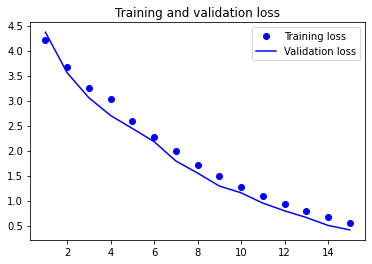

In [34]:
acc = history.history['acc']
 
val_acc = history.history['val_acc'] 
loss = history.history['loss']
val_loss = history.history['val_loss']; 
epochs = range(1, len(acc) + 1) 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend(loc='best')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')

In [35]:
loss, accuracy, f1_score = model.evaluate(X_test, y_test, verbose=0)

2021-12-01 17:28:25.274597: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 146610000 exceeds 10% of free system memory.
2021-12-01 17:28:25.447603: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 146610000 exceeds 10% of free system memory.


In [36]:
print('val_accuracy', accuracy)
print('f1_score', f1_score)

val_accuracy 0.9309391975402832
f1_score 0.9287858009338379
